# NanoGPT: A Minimal GPT Implementation

This notebook implements a minimal GPT (Generative Pre-trained Transformer) model trained on the Tiny Shakespeare dataset. The implementation follows the transformer architecture with:

- Token and positional embeddings
- Multi-head self-attention with causal masking
- Feed-forward neural networks
- Layer normalization

Reference: "Attention Is All You Need" (Vaswani et al., 2017)

In [1]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math
import requests
import tiktoken
from tqdm import tqdm

# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if device == 'cuda':
    torch.cuda.manual_seed(42)

Using device: cuda


In [2]:
# download the tiny shakespeare dataset
input_file_path = os.path.join(os.getcwd(), 'input.txt')
if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w', encoding='utf-8') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r', encoding='utf-8') as f:
    data = f.read()
n = len(data)
train_data = data[:int(n*0.9)]
val_data = data[int(n*0.9):]
print(f"train has {len(train_data):,} characters")
print(f"val has {len(val_data):,} characters")

# encode with tiktoken gpt2 bpe
enc = tiktoken.get_encoding("gpt2")
train_ids = enc.encode_ordinary(train_data)
val_ids = enc.encode_ordinary(val_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

# export to bin files
train_ids = np.array(train_ids, dtype=np.uint16)
val_ids = np.array(val_ids, dtype=np.uint16)
train_ids.tofile(os.path.join(os.getcwd(), 'train.bin'))
val_ids.tofile(os.path.join(os.getcwd(), 'val.bin'))

train has 1,003,854 characters
val has 111,540 characters
train has 301,966 tokens
val has 36,059 tokens


In [ ]:
# Hyperparameters Configuration

# Model architecture
D_model = 256          # Embedding dimension (reduced from 384)
N_layers = 4           # Number of transformer blocks (reduced from 6)
N_heads = 4            # Number of attention heads (reduced from 6)
D_head = D_model // N_heads  # Dimension per head
D_FF = 4 * D_model     # Feedforward layer dimension
Vocab_size = enc.n_vocab  # GPT-2 vocabulary size (50257)
Block_size = 128       # Maximum context length (reduced from 256)
Dropout = 0.2          # Dropout rate

# Training parameters
Batch_size = 16        # Number of sequences per batch (reduced from 64)
Learning_rate = 3e-4   # Learning rate
Max_iters = 5000       # Total training iterations
Eval_interval = 500    # Evaluation frequency
Eval_iters = 200       # Number of batches for evaluation

print(f"Model Configuration:")
print(f"  Embedding dimension (D_model): {D_model}")
print(f"  Number of layers: {N_layers}")
print(f"  Number of attention heads: {N_heads}")
print(f"  Head dimension: {D_head}")
print(f"  Feedforward dimension: {D_FF}")
print(f"  Vocabulary size: {Vocab_size}")
print(f"  Context length: {Block_size}")
print(f"  Dropout: {Dropout}")
print(f"\nTraining Configuration:")
print(f"  Batch size: {Batch_size}")
print(f"  Learning rate: {Learning_rate}")
print(f"  Max iterations: {Max_iters}")
print(f"\nNote: Model size reduced to fit in GPU memory")

Model Configuration:
  Embedding dimension (D_model): 256
  Number of layers: 4
  Number of attention heads: 4
  Head dimension: 64
  Feedforward dimension: 1024
  Vocabulary size: 50257
  Context length: 128
  Dropout: 0.2

Training Configuration:
  Batch size: 16
  Learning rate: 0.0003
  Max iterations: 5000

Note: Model size reduced to fit in GPU memory


In [4]:
# Model Architecture Components

class Head(nn.Module):
    """Single head of self-attention with causal masking."""
    
    def __init__(self, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)    # (B, T, head_size)
        q = self.query(x)  # (B, T, head_size)
        
        # Compute attention scores with scaled dot-product
        wei = q @ k.transpose(-2, -1) * (k.shape[-1] ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # Causal mask
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        
        # Weighted aggregation of values
        v = self.value(x)  # (B, T, head_size)
        out = wei @ v      # (B, T, head_size)
        return out


class MultiHeadAttention(nn.Module):
    """Multi-head self-attention with parallel heads."""
    
    def __init__(self, num_heads, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embd, block_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedForward(nn.Module):
    """Position-wise feed-forward network with GELU activation."""
    
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )
        
    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """Transformer block: communication (attention) followed by computation (ffn)."""
    
    def __init__(self, n_embd, n_head, block_size, dropout):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd, block_size, dropout)
        self.ffwd = FeedForward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        
    def forward(self, x):
        x = x + self.sa(self.ln1(x))   # Pre-norm residual connection
        x = x + self.ffwd(self.ln2(x)) # Pre-norm residual connection
        return x


class NanoGPT(nn.Module):
    """GPT Language Model."""
    
    def __init__(self, vocab_size, n_embd, n_layer, n_head, block_size, dropout):
        super().__init__()
        self.block_size = block_size
        
        # Token and position embeddings
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        
        # Transformer blocks
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)])
        
        # Final layer norm and output projection
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            
    def forward(self, idx, targets=None):
        B, T = idx.shape
        
        # Get token and position embeddings
        tok_emb = self.token_embedding_table(idx)  # (B, T, n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))  # (T, n_embd)
        x = tok_emb + pos_emb  # (B, T, n_embd)
        
        # Apply transformer blocks
        x = self.blocks(x)      # (B, T, n_embd)
        x = self.ln_f(x)        # (B, T, n_embd)
        logits = self.lm_head(x)  # (B, T, vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
            
        return logits, loss
    
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """Generate new tokens autoregressively."""
        for _ in range(max_new_tokens):
            # Crop context to block_size
            idx_cond = idx[:, -self.block_size:]
            
            # Get predictions
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature  # Focus on last time step
            
            # Optional top-k sampling
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = float('-inf')
            
            # Apply softmax and sample
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
            
        return idx

# Calculate model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Initialize model
model = NanoGPT(
    vocab_size=Vocab_size,
    n_embd=D_model,
    n_layer=N_layers,
    n_head=N_heads,
    block_size=Block_size,
    dropout=Dropout
).to(device)

print(f"Model initialized with {count_parameters(model):,} parameters")
print(f"\nModel Architecture:")
print(model)

Model initialized with 28,971,089 parameters

Model Architecture:
NanoGPT(
  (token_embedding_table): Embedding(50257, 256)
  (position_embedding_table): Embedding(128, 256)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=256, out_features=64, bias=False)
            (query): Linear(in_features=256, out_features=64, bias=False)
            (value): Linear(in_features=256, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=1024, out_features=256, bias=True)
          (3): Dropout(p=0.2, inplace=False)


In [5]:
# Data Loading Utilities

def get_batch(split):
    """Generate a batch of data for training or validation."""
    data = train_ids if split == 'train' else val_ids
    ix = torch.randint(len(data) - Block_size, (Batch_size,))
    x = torch.stack([torch.from_numpy(data[i:i+Block_size].astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy(data[i+1:i+Block_size+1].astype(np.int64)) for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


@torch.no_grad()
def estimate_loss():
    """Estimate loss on train and validation sets."""
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(Eval_iters)
        for k in range(Eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


# Test data loading
xb, yb = get_batch('train')
print(f"Input batch shape: {xb.shape}")
print(f"Target batch shape: {yb.shape}")
print(f"Sample input sequence (first 10 tokens): {xb[0, :10].tolist()}")
print(f"Sample target sequence (first 10 tokens): {yb[0, :10].tolist()}")

Input batch shape: torch.Size([16, 128])
Target batch shape: torch.Size([16, 128])
Sample input sequence (first 10 tokens): [2767, 25, 198, 2061, 1276, 307, 2236, 307, 13, 198]
Sample target sequence (first 10 tokens): [25, 198, 2061, 1276, 307, 2236, 307, 13, 198, 198]


In [6]:
# Training Loop

# Initialize optimizer
optimizer = optim.AdamW(model.parameters(), lr=Learning_rate)

# Learning rate scheduler with warmup and cosine decay
def get_lr(it):
    warmup_iters = 100
    lr_decay_iters = Max_iters
    min_lr = Learning_rate / 10
    
    # Warmup phase
    if it < warmup_iters:
        return Learning_rate * it / warmup_iters
    # After decay, return minimum learning rate
    if it > lr_decay_iters:
        return min_lr
    # Cosine decay
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (Learning_rate - min_lr)

# Training tracking
train_losses = []
val_losses = []
iterations = []

print("Starting training...")
print("-" * 50)

for iter in range(Max_iters):
    # Update learning rate
    lr = get_lr(iter)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    # Evaluate periodically
    if iter % Eval_interval == 0 or iter == Max_iters - 1:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        iterations.append(iter)
        print(f"Step {iter:5d}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, lr {lr:.2e}")
    
    # Get batch and compute loss
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    
    # Backpropagation
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    optimizer.step()

print("-" * 50)
print("Training complete!")

Starting training...
--------------------------------------------------
Step     0: train loss 10.9146, val loss 10.9146, lr 0.00e+00
Step   500: train loss 4.4289, val loss 5.0244, lr 2.96e-04
Step  1000: train loss 3.8588, val loss 4.7691, lr 2.78e-04
Step  1500: train loss 3.4888, val loss 4.8144, lr 2.49e-04
Step  2000: train loss 3.1942, val loss 4.8719, lr 2.12e-04
Step  2500: train loss 2.9525, val loss 4.9581, lr 1.69e-04
Step  3000: train loss 2.7539, val loss 5.0788, lr 1.27e-04
Step  3500: train loss 2.5953, val loss 5.1477, lr 8.78e-05
Step  4000: train loss 2.4929, val loss 5.2170, lr 5.68e-05
Step  4500: train loss 2.4114, val loss 5.2326, lr 3.69e-05
Step  4999: train loss 2.3520, val loss 5.3350, lr 3.00e-05
--------------------------------------------------
Training complete!


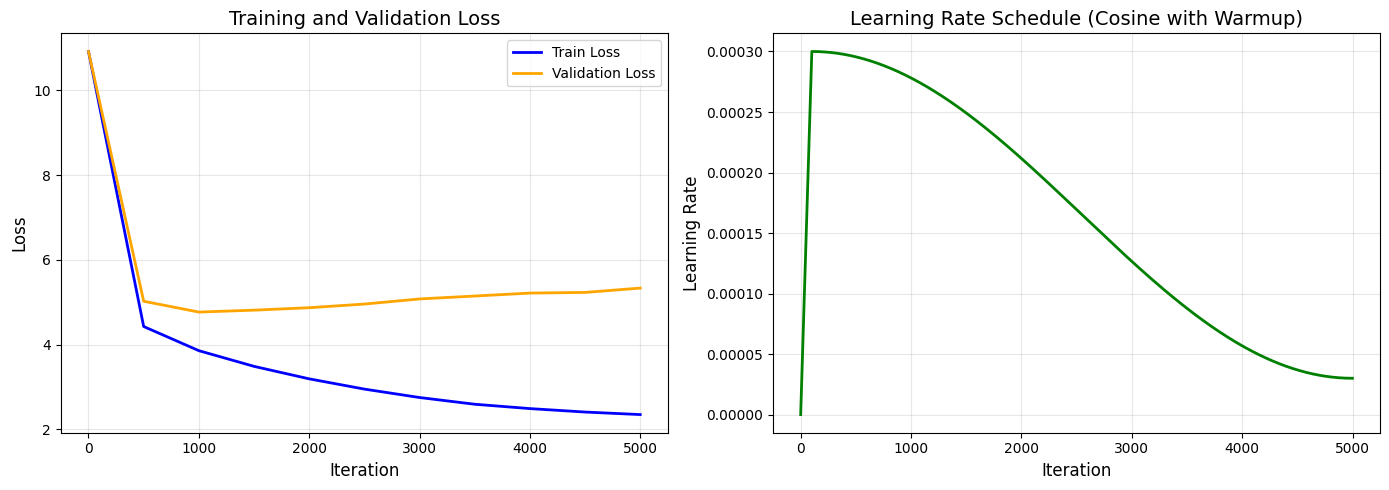


Final Training Loss: 2.3520
Final Validation Loss: 5.3350


In [7]:
# Training Visualization

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(iterations, train_losses, label='Train Loss', color='blue', linewidth=2)
axes[0].plot(iterations, val_losses, label='Validation Loss', color='orange', linewidth=2)
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Learning rate schedule visualization
lr_schedule = [get_lr(i) for i in range(Max_iters)]
axes[1].plot(range(Max_iters), lr_schedule, color='green', linewidth=2)
axes[1].set_xlabel('Iteration', fontsize=12)
axes[1].set_ylabel('Learning Rate', fontsize=12)
axes[1].set_title('Learning Rate Schedule (Cosine with Warmup)', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final statistics
print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
print(f"Final Validation Loss: {val_losses[-1]:.4f}")

In [8]:
# Text Generation

def generate_text(prompt, max_tokens=500, temperature=0.8, top_k=40):
    """Generate text from a given prompt."""
    model.eval()
    
    # Encode the prompt
    context = torch.tensor([enc.encode(prompt)], dtype=torch.long, device=device)
    
    # Generate tokens
    with torch.no_grad():
        generated = model.generate(context, max_new_tokens=max_tokens, temperature=temperature, top_k=top_k)
    
    # Decode and return
    return enc.decode(generated[0].tolist())


# Generate sample text with different prompts
print("=" * 60)
print("TEXT GENERATION SAMPLES")
print("=" * 60)

prompts = [
    "ROMEO:",
    "To be or not to be",
    "The king",
]

for prompt in prompts:
    print(f"\nPrompt: \"{prompt}\"")
    print("-" * 40)
    generated = generate_text(prompt, max_tokens=200, temperature=0.8, top_k=40)
    print(generated)
    print("-" * 40)

TEXT GENERATION SAMPLES

Prompt: "ROMEO:"
----------------------------------------
ROMEO:
I'll not speak too: it, and thou must love my life.

JULIET:
I cannot do it.

JULIET:
Thou art a word to thee.
FRIAR LAURENCE:
And Juliet is not mine, be married to my breast!

PARIS:
I am a word, and Romeo!

JULIET:
Thou art a word in love, and thou sociable, now not now art
Hence from art true: thou art tost, by blood,
that thou art a poor infants, in their hell.

DUKE OF YORK:
Go, do; I'll be brief, and be gone.

Nurse:
God grant me! where is I beseech you,
To see your grace, here have no other gage,
To speak with a thousand men may prove.

DUCH
----------------------------------------

Prompt: "To be or not to be"
----------------------------------------
To be or not to be the deed.

KING RICHARD III:
I will take her in this marriage: there
When my husband, think I have made her king;
And thus I had, to take her at mine arms
But there's no harm had none bad.

QUEEN ELIZABETH:
I know the king t

In [9]:
# Save and Load Model

# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'config': {
        'vocab_size': Vocab_size,
        'n_embd': D_model,
        'n_layer': N_layers,
        'n_head': N_heads,
        'block_size': Block_size,
        'dropout': Dropout,
    }
}

save_path = os.path.join(os.getcwd(), 'nanogpt_checkpoint.pt')
torch.save(checkpoint, save_path)
print(f"Model checkpoint saved to: {save_path}")

# To load the model later:
# checkpoint = torch.load('nanogpt_checkpoint.pt')
# model.load_state_dict(checkpoint['model_state_dict'])

Model checkpoint saved to: d:\2_ML PROJECTS\Hello World of modern Deep Learning\nanogpt_checkpoint.pt


In [10]:
# Interactive Generation (Optional)

def interactive_generate():
    """Interactive text generation interface."""
    print("Interactive Text Generation")
    print("Type 'quit' to exit")
    print("-" * 40)
    
    while True:
        prompt = input("\nEnter prompt: ")
        if prompt.lower() == 'quit':
            break
        
        try:
            temp = float(input("Temperature (0.1-2.0, default 0.8): ") or "0.8")
            tokens = int(input("Max tokens (default 200): ") or "200")
        except ValueError:
            temp, tokens = 0.8, 200
        
        print("\nGenerating...")
        generated = generate_text(prompt, max_tokens=tokens, temperature=temp)
        print("\n" + generated)

# Uncomment to run interactive mode:
# interactive_generate()

## Summary

This notebook implements NanoGPT with the following components:

**Architecture:**
- Token embeddings with learned positional embeddings
- Multi-head causal self-attention with scaled dot-product attention
- Pre-norm transformer blocks with residual connections
- GELU activation in feed-forward layers
- Dropout for regularization

**Training:**
- AdamW optimizer with weight decay
- Learning rate schedule with linear warmup and cosine decay
- Gradient clipping for stable training
- Cross-entropy loss for next-token prediction

**Generation:**
- Autoregressive token generation
- Temperature sampling for output diversity
- Top-k sampling for quality control

**Model Size:** ~10M parameters (varies based on configuration)

For better results, consider:
- Training for more iterations
- Increasing model size (D_model, N_layers)
- Using larger batch sizes with gradient accumulation
- Fine-tuning hyperparameters